<a href="https://colab.research.google.com/github/yosedie/ai-project/blob/main/ai_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ai-project

https://id.wikibooks.org/wiki/Permainan_Tradisional_%22Catur%22_di_Indonesia/Macanan_(Yogyakarta)#Macanan_8_uwong_dan_2_macan

=== Macanan 8 ''uwong'' dan 2 ''macan'' ===

map di GUI

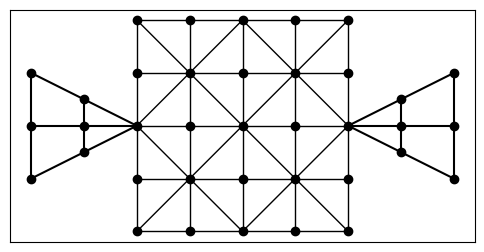

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def draw_board(size):
    # Ukuran grid
    gap = size // 5
    node_radius = 0.08

    # Menyiapkan array untuk posisi nodes
    nodes_pos = []

    # Membuat plot untuk papan
    fig, ax = plt.subplots(figsize=(6, 6))

    # Menggambar grid
    for row in range(5):
        for col in range(5):
            x = col * gap
            y = row * gap
            ax.plot(x, y, 'ko', markersize=6)  # Titik

            # Garis horizontal dan vertikal
            if col < 4:  # Horizontal
                ax.plot([x, x + gap], [y, y], 'k-', lw=1)
            if row < 4:  # Vertikal
                ax.plot([x, x], [y, y + gap], 'k-', lw=1)

            # Garis diagonal bergantian
            if col < 4 and row < 4:
                if (row + col) % 2 == 0:
                    ax.plot([x, x + gap], [y, y + gap], 'k-', lw=1)  # Diagonal \
                else:
                    ax.plot([x + gap, x], [y, y + gap], 'k-', lw=1)  # Diagonal /

            nodes_pos.append((x, y))

    # Segitiga kiri
    left_center_x = 0
    left_center_y = 2 * gap
    triangle_width = 2 * gap
    ax.plot([left_center_x, left_center_x - triangle_width], [left_center_y, left_center_y - gap], 'k-')
    ax.plot([left_center_x, left_center_x - triangle_width], [left_center_y, left_center_y + gap], 'k-')
    ax.plot([left_center_x - triangle_width, left_center_x - triangle_width],
            [left_center_y - gap, left_center_y + gap], 'k-')

    ax.plot([left_center_x - gap, left_center_x - gap],
            [left_center_y - gap/2, left_center_y + gap/2], 'k-')
    ax.plot([left_center_x - triangle_width, left_center_x],
            [left_center_y, left_center_y], 'k-')

    left_nodes = [
        (left_center_x - triangle_width, left_center_y - gap),
        (left_center_x - triangle_width, left_center_y),
        (left_center_x - triangle_width, left_center_y + gap),
        (left_center_x - gap, left_center_y - gap/2),
        (left_center_x - gap, left_center_y),
        (left_center_x - gap, left_center_y + gap/2),
    ]

    for (x, y) in left_nodes:
        ax.plot(x, y, 'ko', markersize=6)

    nodes_pos.extend(left_nodes)

    # Segitiga kanan
    right_center_x = 4 * gap
    right_center_y = 2 * gap
    ax.plot([right_center_x, right_center_x + triangle_width],
            [right_center_y, right_center_y - gap], 'k-')
    ax.plot([right_center_x, right_center_x + triangle_width],
            [right_center_y, right_center_y + gap], 'k-')
    ax.plot([right_center_x + triangle_width, right_center_x + triangle_width],
            [right_center_y - gap, right_center_y + gap], 'k-')

    ax.plot([right_center_x + gap, right_center_x + gap],
            [right_center_y - gap/2, right_center_y + gap/2], 'k-')
    ax.plot([right_center_x, right_center_x + triangle_width],
            [right_center_y, right_center_y], 'k-')

    right_nodes = [
        (right_center_x + triangle_width, right_center_y - gap),
        (right_center_x + triangle_width, right_center_y),
        (right_center_x + triangle_width, right_center_y + gap),
        (right_center_x + gap, right_center_y - gap/2),
        (right_center_x + gap, right_center_y),
        (right_center_x + gap, right_center_y + gap/2),
    ]

    for (x, y) in right_nodes:
        ax.plot(x, y, 'ko', markersize=6)

    nodes_pos.extend(right_nodes)

    # Pengaturan sumbu dan tampilan
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    # Menampilkan papan
    plt.show()

# Panggil fungsi untuk menggambar papan
draw_board(400)


map di CUI

In [38]:
def draw_board(size):
    gap = size // 5  # Ukuran jarak antar titik
    grid = [[' ' for _ in range(5)] for _ in range(5)]  # Inisialisasi grid 5x5

    # Mengisi titik-titik pada grid 5x5
    for row in range(5):
        for col in range(5):
            grid[row][col] = '.'

    # Menambahkan titik pada segitiga kiri
    left_triangle = [
        (2, 0),
        (1, 1),
        (1, 3),
        (0, 1),
        (0, 2),
        (0, 3)
    ]
    for (r, c) in left_triangle:
        grid[r][c] = '.'

    # Menambahkan titik pada segitiga kanan
    right_triangle = [
        (2, 4),
        (3, 1),
        (3, 3),
        (4, 1),
        (4, 2),
        (4, 3)
    ]
    for (r, c) in right_triangle:
        grid[r][c] = '.'

    # Menampilkan grid
    for row in grid:
        print(' '.join(row))

# Menampilkan papan
draw_board(400)


. . . . .
. . . . .
. . . . .
. . . . .
. . . . .


2 player

In [3]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

# Menampilkan papan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    if (x, y) not in valid_positions:
        print(f"Invalid position: {(x, y)} is not a valid position.")
        return False
    if board[x, y] != 0:
        print(f"Invalid position: {(x, y)} is already occupied.")
        return False
    return True

# Peletakan awal pion
def place_piece(player, x, y):
    if (x, y) in valid_positions and board[x, y] == 0:
        board[x, y] = player
        return True
    return False

# Cek apakah melompati pion uwong
def can_jump(x1, y1, x2, y2):
    dx, dy = (x2 - x1) // 2, (y2 - y1) // 2  # Arah lompat
    mid_x, mid_y = x1 + dx, y1 + dy
    if board[mid_x, mid_y] != 2:
        print(f"Cannot jump: No uwong at middle position {(mid_x, mid_y)}.")
        return False
    return True

# Gerakan pion
def move_piece(player, x1, y1, x2, y2):
    print(f"Validating move for player {player} from {(x1, y1)} to {(x2, y2)}")
    if board[x1, y1] != player:  # Pastikan posisi awal benar
        print(f"Invalid move: Starting position does not belong to player {player}.")
        return False
    if not is_valid_move(x2, y2):  # Pastikan posisi tujuan valid
        print(f"Invalid move: Target position {(x2, y2)} is not valid.")
        return False
    if player == 1 and abs(x2 - x1) == 2 and abs(y2 - y1) == 2:  # Melompat
        if not can_jump(x1, y1, x2, y2):
            print(f"Invalid jump: No uwong to jump over from {(x1, y1)} to {(x2, y2)}.")
            return False
    elif abs(x2 - x1) > 1 or abs(y2 - y1) > 1:  # Gerakan biasa terlalu jauh
        print(f"Invalid move: Movement exceeds one step from {(x1, y1)} to {(x2, y2)}.")
        return False
    # Gerakan valid
    board[x1, y1] = 0
    board[x2, y2] = player
    return True

# Kondisi akhir permainan
def check_end_game():
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]

    if not uwong_positions:  # Tidak ada uwong tersisa
        print("Macan menang! Semua uwong telah diterkam.")
        return True

    # Cek apakah macan tidak bisa bergerak
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):
                return False
            if dx % 2 == 0 and can_jump(mx, my, nx, ny):
                return False

    print("Uwong menang! Semua macan tidak dapat bergerak.")
    return True

# Logika giliran
def player_turn(player):
    print_board()
    print("Giliran Macan" if player == 1 else "Giliran Uwong")
    try:
        x, y = map(int, input("Masukkan posisi awal (x y): ").split())
        if player == 1:  # Macan bergerak
            x2, y2 = map(int, input("Masukkan posisi tujuan (x y): ").split())
            if move_piece(player, x, y, x2, y2):
                return True
        else:  # Uwong meletakkan pion
            if place_piece(player, x, y):
                return True
    except ValueError:
        print("Input invalid. Masukkan angka dengan format 'x y'.")
    print("Langkah tidak valid, coba lagi.")
    return False


def is_valid_move_macan(start, target, board):
    # Pastikan target kosong
    if board[target[0]][target[1]] != ".":
        return False
    # Pastikan langkah valid (1 langkah atau melompat pion uwong)
    dx, dy = abs(start[0] - target[0]), abs(start[1] - target[1])
    if dx <= 1 and dy <= 1:  # 1 langkah
        return True
    if dx > 1 or dy > 1:  # Melompat
        if (dx == dy or dx == 0 or dy == 0):  # Dalam satu garis
            # Cek jumlah pion uwong di jalur
            uwong_count = count_uwong_in_path(start, target, board)
            return uwong_count % 2 == 0  # Harus genap
    return False

# Permainan utama
def main():
    uwong_count = 8
    placed_uwong = 0
    macan_count = 2
    current_player = 1  # Macan memulai permainan

    # Peletakan awal pion macan
    print("Letakkan pion Macan pertama:")
    while not place_piece(1, 0, 0):  # Misalnya, letakkan pion di (0, 0)
        pass
    print("Letakkan pion Macan kedua:")
    while not place_piece(1, 2, 2):  # Misalnya, letakkan pion kedua di (2, 2)
        pass

    while True:
        if current_player == 1:  # Giliran macan
            if not player_turn(1):
                continue
        else:  # Giliran uwong
            if placed_uwong < uwong_count:
                if not player_turn(2):
                    continue
                placed_uwong += 1
            else:  # Uwong habis, mulai bergerak
                if not player_turn(2):
                    continue

        # Cek kondisi akhir permainan
        if check_end_game():
            print_board()
            break

        # Ganti giliran
        current_player = 3 - current_player  # Bergantian 1 -> 2, 2 -> 1

if __name__ == "__main__":
    main()

Letakkan pion Macan pertama:
Letakkan pion Macan kedua:
 M     .     . 
    .     .    
 .  .  M  .  . 
    .     .    
 .     .     . 


Giliran Macan
Masukkan posisi awal (x y): 2 2
Masukkan posisi tujuan (x y):  3 3
Validating move for player 1 from (2, 2) to (3, 3)
Macan menang! Semua uwong telah diterkam.
 M     .     . 
    .     .    
 .  .  .  .  . 
    .     M    
 .     .     . 




AI macan

In [ ]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

# Menampilkan papan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    return (x, y) in valid_positions and board[x, y] == 0

def place_uwong_player(board):
    print("Letakkan pion Uwong!")
    while True:
        x, y = map(int, input("Masukkan posisi Uwong (x y): ").split())
        if (x, y) in valid_positions and board[x, y] == 0:
            board[x, y] = 2
            break
        else:
            print(f"Posisi ({x}, {y}) sudah terisi atau tidak valid!")

def place_macan_ai(board):
    # Memastikan hanya ada dua pion Macan
    if np.sum(board == 1) >= 2:
        print("Macan sudah memiliki dua pion. Tidak bisa menambah lebih dari dua.")
        return False  # Tidak meletakkan pion lagi jika sudah ada 2 pion Macan

    available_positions = [(i, j) for i, j in valid_positions if board[i, j] == 0]
    if available_positions:
        chosen_pos = available_positions[0]  # Pilih posisi pertama yang kosong
        board[chosen_pos[0], chosen_pos[1]] = 1  # Pion Macan
        print(f"AI menempatkan pion Macan di {chosen_pos}")
        return True
    return False

# Cek apakah Macan bisa bergerak
def can_macans_move(board):
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):  # Gerakan biasa
                return True
            if can_jump(mx, my, nx, ny):  # Lompat di atas Uwong
                return True
    return False

# Cek jika Macan bisa lompat ke posisi tertentu
def can_jump(mx, my, nx, ny):
    middle_x, middle_y = (mx + nx) // 2, (my + ny) // 2
    if (middle_x, middle_y) in valid_positions and board[middle_x, middle_y] == 2:  # Ada Uwong di tengah
        return True
    return False

# Menilai kondisi akhir permainan
def game_over(board):
    if np.sum(board == 2) == 0:  # Jika tidak ada Uwong
        print("Macan menang! Semua Uwong telah diterkam.")
        return True

    if not can_macans_move(board):  # Jika Macan tidak bisa bergerak
        print("Macan kalah! Macan tidak bisa bergerak.")
        return True

    return False

# Fungsi untuk mencari semua langkah yang mungkin untuk pemain
def get_all_possible_moves(board, player):
    moves = []
    if player == 2:  # Uwong
        uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]
        for ux, uy in uwong_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = ux + dx, uy + dy
                if is_valid_move(nx, ny):
                    moves.append(((ux, uy), (nx, ny)))
    elif player == 1:  # Macan
        macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
        for mx, my in macan_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
                nx, ny = mx + dx, my + dy
                if is_valid_move(nx, ny) or can_jump(mx, my, nx, ny):  # Jika bisa bergerak atau lompat
                    moves.append(((mx, my), (nx, ny)))
    return moves

# Terapkan langkah pada papan
def apply_move(board, move, player):
    new_board = board.copy()
    (x1, y1), (x2, y2) = move
    new_board[x2, y2] = player
    new_board[x1, y1] = 0
    return new_board

# Minimax algorithm
def minimax(board, depth, is_maximizing_player):
    if depth == 0 or game_over(board):
        return evaluate(board)

    if is_maximizing_player:  # Macan (AI)
        max_eval = float('-inf')
        for move in get_all_possible_moves(board, player=1):  # Macan
            new_board = apply_move(board, move, player=1)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:  # Uwong (Player)
        min_eval = float('inf')
        for move in get_all_possible_moves(board, player=2):  # Uwong
            new_board = apply_move(board, move, player=2)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Evaluasi papan
def evaluate(board):
    # Penilaian sederhana: lebih banyak Uwong, lebih buruk bagi Macan
    uwong_count = np.sum(board == 2)
    macan_count = np.sum(board == 1)
    return uwong_count - macan_count  # Uwong menang lebih baik

# Fungsi untuk memilih langkah terbaik untuk Macan menggunakan AI (Minimax)
def minimax_ai(board):
    best_score = float('-inf')
    best_move = None
    for move in get_all_possible_moves(board, player=1):  # Macan
        new_board = apply_move(board, move, player=1)
        score = minimax(new_board, 3, False)  # Kedalaman 3
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi permainan utama
def main():
    uwong_count = 8
    placed_uwong = 0
    macan_count = 2
    current_player = 2  # Player mulai dengan Uwong (2)

    # Peletakan pion Uwong oleh player
    print_board()
    while placed_uwong < uwong_count:
        place_uwong_player(board)
        placed_uwong += 1
        print_board()

    # Peletakan pion Macan oleh AI
    print("AI meletakkan pion Macan.")
    for _ in range(macan_count):
        if not place_macan_ai(board):  # Jika sudah ada 2 pion Macan, hentikan peletakan
            break
        print_board()

    # Permainan dimulai setelah peletakan selesai
    while True:
        print_board()

        if current_player == 2:  # Giliran Uwong (Player)
            print("Giliran Uwong (Player)")
            x, y = map(int, input("Masukkan posisi awal (x y): ").split())
            x2, y2 = map(int, input("Masukkan posisi tujuan (x y): ").split())

            if is_valid_move(x2, y2):  # Validasi langkah
                board[x2, y2] = 2
                board[x, y] = 0
                current_player = 1  # Ganti giliran ke Macan (AI)
            else:
                print("Posisi tidak valid atau sudah terisi.")

        if game_over(board):  # Periksa apakah permainan sudah berakhir setelah langkah
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

        if current_player == 1:  # Giliran Macan (AI)
            print("Giliran Macan (AI)")

            # Pilih langkah terbaik untuk Macan menggunakan AI (Minimax)
            move = minimax_ai(board)
            if move:
                (x1, y1), (x2, y2) = move
                board[x2, y2] = 1
                board[x1, y1] = 0
                current_player = 2  # Ganti giliran ke Uwong (Player)

if __name__ == "__main__":
    main()


AI uwong

In [2]:
import numpy as np

# Representasi papan sebagai matriks
board = np.zeros((5, 5), dtype=int)

# Koordinat valid (bentuk papan permainan)
valid_positions = [
    (0, 0), (0, 2), (0, 4),
    (1, 1), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    (3, 1), (3, 3),
    (4, 0), (4, 2), (4, 4)
]

# Menampilkan papan
def print_board():
    for i in range(5):
        row = ""
        for j in range(5):
            if (i, j) not in valid_positions:
                row += "   "  # Posisi tidak valid
            elif board[i, j] == 0:
                row += " . "  # Kosong
            elif board[i, j] == 1:
                row += " M "  # Macan
            elif board[i, j] == 2:
                row += " U "  # Uwong
        print(row)
    print("\n")

# Cek apakah langkah valid
def is_valid_move(x, y):
    return (x, y) in valid_positions and board[x, y] == 0

def place_uwong_player(board):
    print("Letakkan pion Uwong!")
    while True:
        x, y = map(int, input("Masukkan posisi Uwong (x y): ").split())
        if (x, y) in valid_positions and board[x, y] == 0:
            board[x, y] = 2
            break
        else:
            print(f"Posisi ({x}, {y}) sudah terisi atau tidak valid!")

def place_macan_ai(board):
    # Memastikan hanya ada dua pion Macan
    if np.sum(board == 1) >= 2:
        print("Macan sudah memiliki dua pion. Tidak bisa menambah lebih dari dua.")
        return False  # Tidak meletakkan pion lagi jika sudah ada 2 pion Macan

    available_positions = [(i, j) for i, j in valid_positions if board[i, j] == 0]
    if available_positions:
        chosen_pos = available_positions[0]  # Pilih posisi pertama yang kosong
        board[chosen_pos[0], chosen_pos[1]] = 1  # Pion Macan
        print(f"AI menempatkan pion Macan di {chosen_pos}")
        return True
    return False

# Cek apakah Macan bisa bergerak
def can_macans_move(board):
    macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
    for mx, my in macan_positions:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = mx + dx, my + dy
            if is_valid_move(nx, ny):  # Gerakan biasa
                return True
            if can_jump(mx, my, nx, ny):  # Lompat di atas Uwong
                return True
    return False

# Cek jika Macan bisa lompat ke posisi tertentu
def can_jump(mx, my, nx, ny):
    middle_x, middle_y = (mx + nx) // 2, (my + ny) // 2
    if (middle_x, middle_y) in valid_positions and board[middle_x, middle_y] == 2:  # Ada Uwong di tengah
        return True
    return False

# Menilai kondisi akhir permainan
def game_over(board):
    if np.sum(board == 2) == 0:  # Jika tidak ada Uwong
        print("Macan menang! Semua Uwong telah diterkam.")
        return True

    if not can_macans_move(board):  # Jika Macan tidak bisa bergerak
        print("Macan kalah! Macan tidak bisa bergerak.")
        return True

    return False

# Fungsi untuk mencari semua langkah yang mungkin untuk pemain
def get_all_possible_moves(board, player):
    moves = []
    if player == 2:  # Uwong
        uwong_positions = [(i, j) for i, j in valid_positions if board[i, j] == 2]
        for ux, uy in uwong_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = ux + dx, uy + dy
                if is_valid_move(nx, ny):
                    moves.append(((ux, uy), (nx, ny)))
    elif player == 1:  # Macan
        macan_positions = [(i, j) for i, j in valid_positions if board[i, j] == 1]
        for mx, my in macan_positions:
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-2, 0), (2, 0), (0, -2), (0, 2)]:
                nx, ny = mx + dx, my + dy
                if is_valid_move(nx, ny) or can_jump(mx, my, nx, ny):  # Jika bisa bergerak atau lompat
                    moves.append(((mx, my), (nx, ny)))
    return moves

def apply_move(board, move, player):
    new_board = board.copy()
    ((x1, y1), (x2, y2)) = move  # Ambil langkah dari pasangan posisi awal dan posisi tujuan
    if is_valid_move(x2, y2):  # Pastikan langkah yang diterapkan valid
        new_board[x2, y2] = player
        new_board[x1, y1] = 0  # Kosongkan posisi awal
    return new_board

# Minimax algorithm
def minimax(board, depth, is_maximizing_player):
    if depth == 0 or game_over(board):
        return evaluate(board)

    if is_maximizing_player:  # Macan (AI)
        max_eval = float('-inf')
        for move in get_all_possible_moves(board, player=1):  # Macan
            new_board = apply_move(board, move, player=1)
            eval = minimax(new_board, depth - 1, False)
            max_eval = max(max_eval, eval)
        return max_eval
    else:  # Uwong (Player)
        min_eval = float('inf')
        for move in get_all_possible_moves(board, player=2):  # Uwong
            new_board = apply_move(board, move, player=2)
            eval = minimax(new_board, depth - 1, True)
            min_eval = min(min_eval, eval)
        return min_eval

# Evaluasi papan
def evaluate(board):
    # Penilaian sederhana: lebih banyak Uwong, lebih buruk bagi Macan
    uwong_count = np.sum(board == 2)
    macan_count = np.sum(board == 1)
    return uwong_count - macan_count  # Uwong menang lebih baik

# Fungsi untuk memilih langkah terbaik untuk Macan menggunakan AI (Minimax)
def minimax_ai(board):
    best_score = float('-inf')
    best_move = None
    # Ambil semua langkah yang memungkinkan untuk Macan
    for move in get_all_possible_moves(board, player=1):  # Macan (1)
        new_board = apply_move(board, move, player=1)
        score = minimax(new_board, 3, False)  # Kedalaman 3
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Fungsi permainan utama
def main():
    uwong_count = 8
    placed_uwong = 0
    macan_count = 2
    current_player = 2  # Player mulai dengan Uwong (2)

    # Peletakan pion Uwong oleh player
    print_board()
    while placed_uwong < uwong_count:
        place_uwong_player(board)
        placed_uwong += 1
        print_board()

    # Peletakan pion Macan oleh AI
    print("AI meletakkan pion Macan.")
    for _ in range(macan_count):
        if not place_macan_ai(board):  # Jika sudah ada 2 pion Macan, hentikan peletakan
            break
        print_board()

    # Permainan dimulai setelah peletakan selesai
    while True:
        print_board()

        if current_player == 2:  # Giliran Uwong (Player)
            print("Giliran Uwong (Player)")
            x, y = map(int, input("Masukkan posisi awal (x y): ").split())
            x2, y2 = map(int, input("Masukkan posisi tujuan (x y): ").split())

            if is_valid_move(x2, y2):  # Validasi langkah
                board[x2, y2] = 2
                board[x, y] = 0
                current_player = 1  # Ganti giliran ke Macan (AI)
            else:
                print("Posisi tidak valid atau sudah terisi.")

        # Periksa apakah permainan sudah berakhir setelah langkah Uwong
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan

        if current_player == 1:  # Giliran Macan (AI)
            print("Giliran Macan (AI)")

            # Pilih langkah terbaik untuk Macan menggunakan AI (Minimax)
            move = minimax_ai(board)
            if move:
                (x1, y1), (x2, y2) = move
                board[x2, y2] = 1
                board[x1, y1] = 0
                current_player = 2  # Ganti giliran ke Uwong (Player)

        # Periksa apakah permainan sudah berakhir setelah langkah Macan
        if game_over(board):
            print_board()
            break  # Jika permainan berakhir, hentikan perulangan0

if __name__ == "__main__":
    main()


 .     .     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 0 0
 U     .     . 
    .     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 1 1
 U     .     . 
    U     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 0 2
 U     U     . 
    U     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 0 4
 U     U     U 
    U     .    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 1 3
 U     U     U 
    U     U    
 .  .  .  .  . 
    .     .    
 .     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 4 0
 U     U     U 
    U     U    
 .  .  .  .  . 
    .     .    
 U     .     . 


Letakkan pion Uwong!
Masukkan posisi Uwong (x y): 4 2
 U     U     U 
    U     U    
 .  .  .  .  . 


KeyboardInterrupt: Interrupted by user

2 AI